---
title: Overview
description: Juno Orbits and Sunspot Numbers
---

Snunspot data

> We suggest as minimum short-format credit : "Source: WDC-SILSO, Royal Observatory of Belgium, Brussels". or "Sunspot data from the World Data Center SILSO, Royal Observatory of Belgium, Brussels".  

In [1]:
import matplotlib.pyplot as plt
import scienceplots

from space_analysis.utils.cdas import Variables
from space_analysis.plot.basic import savefig
import pandas as pd
import polars as pl

from matplotlib.pyplot import Axes

In [2]:
timerange = ["2011-08-01", "2016-07-01"]
fname = "juno-hg-loc_sunspot-number"

datasets = ['JUNO_HELIO1DAY_POSITION', 'EARTH_HELIO1DAY_POSITION', 'STA_HELIO1DAY_POSITION']
names = ['JUNO', 'EARTH', 'STA']

## Plotting Juno and other mission location

In [4]:
dfs = []

for dataset, name in zip(datasets, names):
    ds_variables = Variables(
        dataset=dataset,
        timerange=timerange,
    )
    df = ds_variables.to_pandas()
    df = df.rename(columns={c: f"{name}_{c}" for c in df.columns})
    dfs.append(df)

2024-02-05 15:04:13.273 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - RAD_AU
2024-02-05 15:04:13.274 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - SE_LAT
2024-02-05 15:04:13.274 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - SE_LON
2024-02-05 15:04:13.274 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - HG_LAT
2024-02-05 15:04:13.275 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - HG_LON
2024-02-05 15:04:13.275 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - HGI_LAT
2024-02-05 15:04:13.275 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - HGI_LON
/Users/zijin/micromamba/envs/space_analysis/lib/python3.12/site-packages/cdflib/xarray/cdf_to_xarray.py:619: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support no

In [5]:
df_concated = pd.concat(dfs, axis=1)

In [6]:
df = pl.DataFrame(df_concated.reset_index()).with_columns(
    JUNO_EARTH_HGI_LON_diff = (pl.col("JUNO_HGI_LON") - pl.col("EARTH_HGI_LON")).abs(),
    JUNO_STA_HGI_LON_diff = (pl.col("JUNO_HGI_LON") - pl.col("STA_HGI_LON")).abs(),
    JUNO_EARTH_HG_LON_diff = (pl.col("JUNO_HG_LON") - pl.col("EARTH_HG_LON")).abs(),
    JUNO_STA_HG_LON_diff = (pl.col("JUNO_HG_LON") - pl.col("STA_HG_LON")).abs(),
).with_columns(
    JUNO_EARTH_HG_LON_diff = pl.when(pl.col("JUNO_EARTH_HG_LON_diff")>180).then(360-pl.col("JUNO_EARTH_HG_LON_diff")).otherwise(pl.col("JUNO_EARTH_HG_LON_diff")),
    JUNO_STA_HG_LON_diff = pl.when(pl.col("JUNO_STA_HG_LON_diff")>180).then(360-pl.col("JUNO_STA_HG_LON_diff")).otherwise(pl.col("JUNO_STA_HG_LON_diff")),
)

In [7]:
def plot_lon_diff(df,ax: Axes):
    ax.plot(df["Epoch"], df["JUNO_EARTH_HG_LON_diff"], label="Juno-Earth")
    ax.plot(df["Epoch"], df["JUNO_STA_HG_LON_diff"], label="Juno-StereoA")
    ax.set_ylabel(r"$\Delta$ HG Longitude")

## Plotting a solar cycle index

https://docs.sunpy.org/en/stable/generated/gallery/plotting/solar_cycle_example.html

In [8]:
%pip install "sunpy[net, timeseries]"

Note: you may need to restart the kernel to use updated packages.


In [9]:
from astropy.time import Time

import sunpy.timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.time import TimeRange

The U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center (SWPC)
provides recent solar cycle indices which includes different sunspot numbers,
radio flux, and geomagnetic index. They also provide predictions for how the
sunspot number and radio flux will evolve. Predicted values are based on the
consensus of the Solar Cycle 24 Prediction Panel.

We will first search for and then download the data.



In [10]:
time_range = TimeRange(timerange)
result = Fido.search(a.Time(time_range), a.Instrument('noaa-indices'))
f_noaa_indices = Fido.fetch(result)

noaa = ts.TimeSeries(f_noaa_indices, source='noaaindices').truncate(time_range)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

/Users/zijin/micromamba/envs/space_analysis/lib/python3.12/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


We then load them into individual `~sunpy.timeseries.TimeSeries` objects.



Finally, we plot both ``noaa`` and ``noaa_predict`` for the sunspot number.
In this case we use the S.I.D.C. Brussels International Sunspot Number (RI).
The predictions provide both a high and low values, which we plot below as
ranges.



In [11]:

def plot_sunspot_number(noaa_indices_ts, ax):
    
    time : Time = noaa_indices_ts.time
    time = time.to_datetime()
    
    ax.scatter(time, noaa_indices_ts.quantity('sunspot RI'))
    ax.plot(time, noaa_indices_ts.quantity('sunspot RI'), label='Monthly')
    ax.plot(
        time, noaa_indices_ts.quantity('sunspot RI smooth'), label='Smoothed'
    )
    
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Sunspot Number')

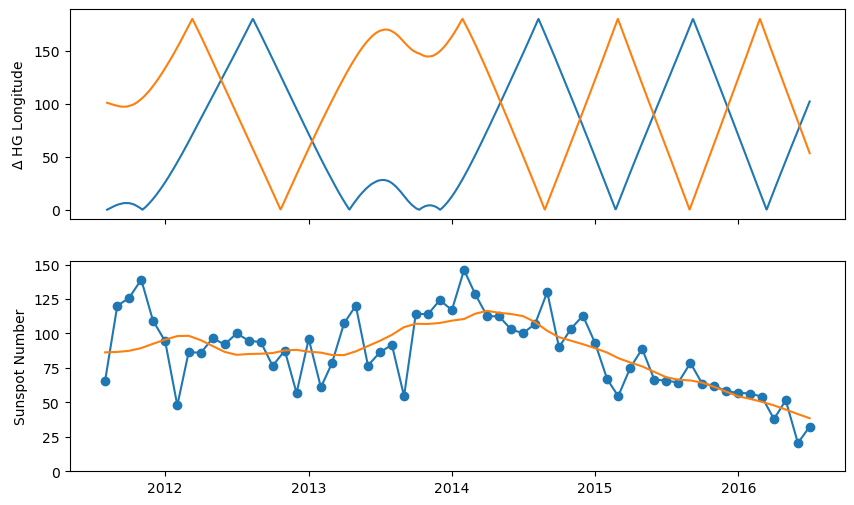

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

plot_lon_diff(df, axes[0])
plot_sunspot_number(noaa, axes[1])

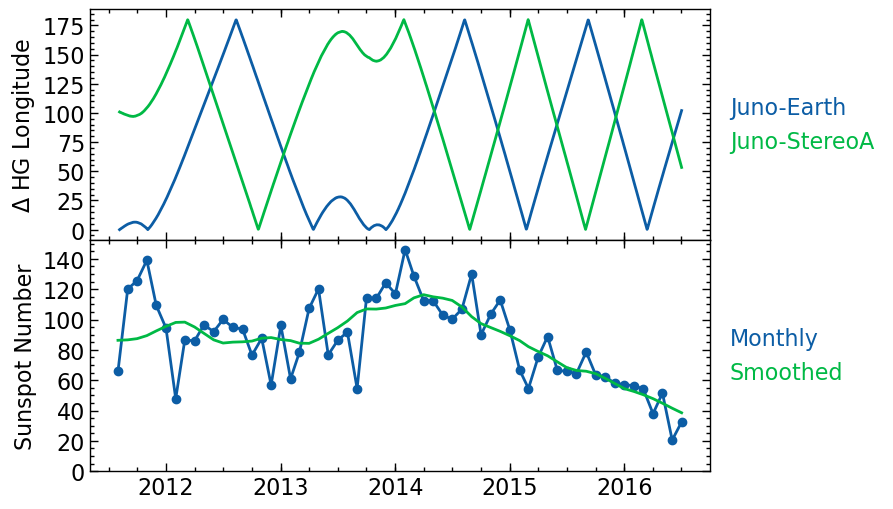

In [13]:
#| label: fig-hg-sunspot
with plt.style.context(['science', 'notebook']):
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)

    plot_lon_diff(df, axes[0])
    plot_sunspot_number(noaa, axes[1])
    
    # axes[0].legend()
    
    for ax in axes:
        legend = ax.legend(handletextpad=0, handlelength=0, loc='center left', bbox_to_anchor=(1, 0.5))
    
        for line, text in zip(legend.get_lines(),legend.get_texts()):
            text.set_color(line.get_color())
    
    plt.subplots_adjust(wspace=0, hspace=0)
    
    savefig(fname)
    